# SIT742: Modern Data Science 
**(Assessment Task 02: Bank Marketing Data Analytics)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, change and distribute this package.

Prepared by **SIT742 Teaching Team**


---

**Project Group Information:**

- Names: Stephen Antony samy  
- Student IDs:
- Emails: santonys@deakin.edu.au 
---

## 1. Import Spark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

## 2. Read and check data

In [0]:
!pip install wget  

In [0]:
import wget

link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
DataSet = wget.download(link_to_data)


In [0]:
!ls

'bank (1).csv'	 sample_data		     spark-2.4.3-bin-hadoop2.7.tgz
 bank.csv	 spark-2.4.3-bin-hadoop2.7   spark-2.4.3-bin-hadoop2.7.tgz.1


In [0]:
spark = SparkSession.builder.appName('ml-bank').getOrCreate()

# Read and import the data " bank.csv" and store in the data frame "df"
df = spark.read.format("csv").option("header","true").load("bank.csv", inferSchema=True)
df.show()

+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  

In [0]:
# check data distribution
# you may use printSchema() 
df.printSchema() 

import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


## 3. Select features

In [0]:
# select features ('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit') as df2
df2 = df.select('age', 'job', 'marital',
'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
'previous', 'poutcome','deposit')
cols = df2.columns
df2.show()

+---+-----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|        job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+-----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 59|     admin.| married|secondary|     no|   2343|    yes|  no|       1|   -1|       0| unknown|    yes|
| 56|     admin.| married|secondary|     no|     45|     no|  no|       1|   -1|       0| unknown|    yes|
| 41| technician| married|secondary|     no|   1270|    yes|  no|       1|   -1|       0| unknown|    yes|
| 55|   services| married|secondary|     no|   2476|    yes|  no|       1|   -1|       0| unknown|    yes|
| 54|     admin.| married| tertiary|     no|    184|     no|  no|       2|   -1|       0| unknown|    yes|
| 42| management|  single| tertiary|     no|      0|    yes| yes|       2|   -1|       0| unknown|    yes|
| 56| management| married| tertiary| 

In [0]:
# remove invalid rows/records using spark.sql 
from pyspark.sql.types import IntegerType

df2.createOrReplaceTempView("df2")

resu1 = spark.sql("SELECT * FROM df2 where age not in ('unknown') AND job not in ('unknown') AND marital not in ('unknown') AND education not in ('unknown') AND default not in ('unknown') AND balance not in ('unknown') AND housing not in ('unknown') AND loan not in ('unknown') AND campaign not in ('unknown') AND pdays not in ('unknown') AND previous not in ('unknown') AND poutcome not in ('unknown','other') AND deposit not in ('unknown')")
resu1.show()

#results.write.csv('mycsv4.csv',header='true')
integer_typ1 = ['age', 'balance', 'campaign', 'pdays','previous']
    
resu1.printSchema() 

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
| 37|  technician| married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|
| 45|entrepreneur| married|secondary|     no|    781|     no| yes|       2|  126|       2| failure|    yes|
| 46|  unemployed|divorced|s

In [0]:
# convert categorical features to numeric features  using One hot encoding, 
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

categorical_Colum1 = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
stages = []

for categorical_Col1 in categorical_Colum1:
    stringIndexer = StringIndexer(inputCol = categorical_Col1, outputCol = categorical_Col1 + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categorical_Col1 + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categorical_Colum1] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features1")
stages += [assembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(results)
df3 = pipelineModel.transform(results)
selectedCols = ['label', 'features1'] + cols
df4 = df3.select(selectedCols)
df4.show()

+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|label|           features1|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|  0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
|  0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
|  0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
|  0.0|(23,[4,10,13,14,1...| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
|  0.0|(23,[1,10,12,14,1...| 37|  technician| married|s

### 3.1 normalisation

In [0]:
# then apply Min-Max normalisation on each attribute using MinMaxScaler  

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
  
scaler_11 = MinMaxScaler(inputCol="features1", outputCol="features")

#Generate the minmax scalar transformed variable
scaler_Model11 = scaler_11.fit(df4)


scaledData = scaler_Model11.transform(df4)

scaledData.schema['features'].metadata=scaledData.schema['features1'].metadata
scaledMeta = scaledData.schema['features1'].metadata

colums = ['label', 'features'] + cols
scaledData = scaledData.select(colums)
scaledData.show()


+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|label|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+-----+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|  0.0|[0.0,0.0,0.0,0.0,...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
|  0.0|[0.0,1.0,0.0,0.0,...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
|  0.0|[0.0,0.0,1.0,0.0,...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
|  0.0|[0.0,0.0,0.0,0.0,...| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
|  0.0|[0.0,1.0,0.0,0.0,...| 37|  technician| married|s

## 4. Unsupervised learning

### 4.1 K-means

In [0]:
# Perform unsupervised learning on df2 with k-means 
# you can use whole df2 as both training and testing data, 
# evaluate the clustering result using Accuracy.  

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

kmeans = KMeans(k=3, seed=1, maxIter=10)  
model_11 = kmeans.fit(scaledData.select("features"))

transformed = model_11.transform(scaledData)
 

output=transformed.select('age', 'job', 'marital','education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays','previous', 'poutcome','deposit','prediction')
output.show()

#determine the silhouette score for calculating the euclidean distance
evaluator = ClusteringEvaluator()
silhouettevalues_11 = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouettevalues_11))

#determine the squared errors
wssse_values = model_11.computeCost(transformed)
print("Within Set Sum of Squared Errors = " + str(wssse_values))

#print the result by using the below functions
center_11 = model_11.clusterCenters()
print("Cluster Centers: ")
for center in center_11:
   print(center)

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+----------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|prediction|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+----------+
| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|         2|
| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|         2|
| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|         1|
| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|         1|
| 37|  technician| married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|         2|
| 45|entrepreneur| married|secondary|     no|   

### 4.2 PCA

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- pcavalues_output: vector (nullable = true)

+--------------------+-------------------+
|               pc[0]|              pc[1]|
+--------------------+-------------------+
|  0.9636424850516068| 0.3313811478935345|
|  0.8373410183626885| 0.3880024159205323|
|-0.10845002652578276| 0.6564023408615134|
|  -0.479560942670008| 1.1082617061107987|
|  0.9576794865061756| 0.2714643678687506|
|  0.787902791896902

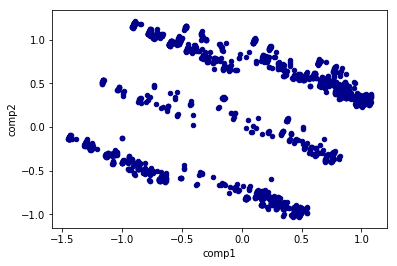

In [0]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import PCA as PCAml
from pyspark.ml.linalg import Vectors 
from pyspark.sql.functions import split,udf, col
from pyspark.sql.types import ArrayType, DoubleType


pca11_values= PCAml(k=15, inputCol="features", outputCol="pcavalues_output")
modelvalues_12 = pca11_values.fit(scaledData)
transformed_2 = modelvalues_12.transform(scaledData)
sum(modelvalues_12.explainedVariance)
transformed_2.printSchema()

output=transformed_2.select('pcavalues_output')

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    return udf(to_array_, ArrayType(DoubleType()))(col)

df5=(output
    .withColumn("pc", to_array(col("pcavalues_output")))
    .select([col("pc")[i] for i in range(2)]))
df5.show()

newdf11_values = df5.toDF("comp1", "comp2")
newdf11_values.printSchema()
pd_df=newdf11_values.toPandas()
pd_df.plot.scatter(x='comp1',y='comp2',c='DarkBlue')

output_2=transformed_2.select('age', 'job', 'marital','education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays','previous', 'poutcome','deposit','pcavalues_output')
output_2.show()

## 5. Supervised learning

In [0]:
train, test = scaledData.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1535
Test Dataset Count: 646


### 5.1 LogisticRegression

In [0]:
# Logistic Regression

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lr_Model11 = log_reg.fit(train)

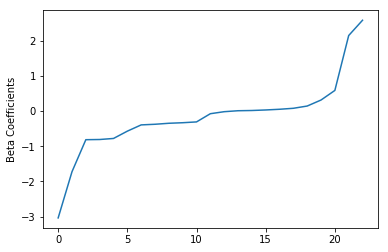

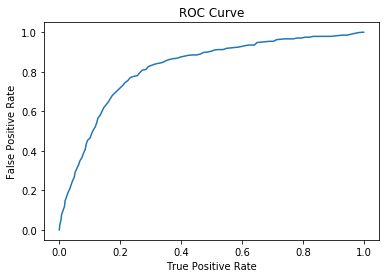

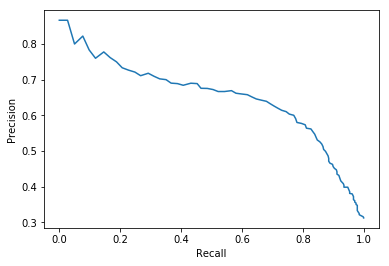

{"metadata":{"ml_attr":{"attrs":{"binary":[{"idx":0,"name":"jobclassVec_management"},{"idx":1,"name":"jobclassVec_technician"},{"idx":2,"name":"jobclassVec_admin."},{"idx":3,"name":"jobclassVec_blue-collar"},{"idx":4,"name":"jobclassVec_retired"},{"idx":5,"name":"jobclassVec_services"},{"idx":6,"name":"jobclassVec_student"},{"idx":7,"name":"jobclassVec_unemployed"},{"idx":8,"name":"jobclassVec_self-employed"},{"idx":9,"name":"jobclassVec_entrepreneur"},{"idx":10,"name":"maritalclassVec_married"},{"idx":11,"name":"maritalclassVec_single"},{"idx":12,"name":"educationclassVec_secondary"},{"idx":13,"name":"educationclassVec_tertiary"},{"idx":14,"name":"defaultclassVec_no"},{"idx":15,"name":"housingclassVec_no"},{"idx":16,"name":"loanclassVec_no"},{"idx":17,"name":"poutcomeclassVec_failure"}],"numeric":[{"idx":18,"name":"age"},{"idx":19,"name":"balance"},{"idx":20,"name":"campaign"},{"idx":21,"name":"pdays"},{"idx":22,"name":"previous"}]},"num_attrs":23}},"name":"features","nullable":true,"

In [0]:
#calculate the coeffecients 
import matplotlib.pyplot as plt
import numpy as np
import json
from pyspark.sql.column import Column

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
              
predictions_11 = lrModel.transform(test).withColumn("features", col("features").alias("", metadata=scaledMeta))

print(predictions_11.schema['features'].json())
print(predictions_11.schema['features'].metadata)

coeff=lrModel.coefficientMatrix
print("Cowfficients Matrix:",coeff)
print("Model Intercept:",lrModel.intercept)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### 5.2 Decision tree

In [0]:
# Decision tree

from pyspark.ml.classification import DecisionTreeClassifier 

train, test = df4.randomSplit([0.7, 0.3], seed = 742)
print("Training Records: " + str(train.count()))
print("Test Records: " + str(test.count()))

deci_tree = DecisionTreeClassifier(featuresCol = 'features1', labelCol = 'label', maxDepth = 3)
dt_Model11 = deci_tree.fit(train)
predictions_11 = dt_Model11.transform(test)
predictions_11.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

evaluator_11 = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator_11.evaluate(predictions, {evaluator_11.metricName: "areaUnderROC"})))

Training Records: 1535
Test Records: 646
+---+----------+-----+-------------+----------+--------------------+
|age|       job|label|rawPrediction|prediction|         probability|
+---+----------+-----+-------------+----------+--------------------+
| 29|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 52|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 48|management|  0.0| [631.0,54.0]|       0.0|[0.92116788321167...|
| 33|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 48|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 49|management|  0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 31|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 32|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 33|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 34|management|  0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
+---+----------+-----+-------------+----------+---------------

### 5.3 NaiveBayes

In [0]:
# NaiveBayes

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = scaledData.randomSplit([0.7, 0.3], seed = 742)
print("Training Records Count: " + str(train.count()))
print("Test Records Count: " + str(test.count()))

nb_11 = NaiveBayes(smoothing=0.1)
model = nb_11.fit(train)

predictions_11 = model.transform(test)
preds_12=predictions_11.filter(predictions_11['prediction'] == 0) \
    .select('age', 'job','probability','label','prediction') \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

Training Records Count: 1535
Test Records Count: 646
+---+----------+------------------------------+-----+----------+
|age|       job|                   probability|label|prediction|
+---+----------+------------------------------+-----+----------+
| 27|   student|[0.962567968803073,0.037432...|  0.0|       0.0|
| 24|   student|[0.9617723073800454,0.03822...|  0.0|       0.0|
| 27|   student|[0.961569329823581,0.038430...|  0.0|       0.0|
| 35|unemployed|[0.9606604907029234,0.03933...|  0.0|       0.0|
| 34|unemployed|[0.9598573267233367,0.04014...|  0.0|       0.0|
| 41|unemployed|[0.9596077433265744,0.04039...|  0.0|       0.0|
| 30|unemployed|[0.9586331914359673,0.04136...|  0.0|       0.0|
| 42|unemployed|[0.9579621298305696,0.04203...|  0.0|       0.0|
| 31|unemployed|[0.9578452260629001,0.04215...|  0.0|       0.0|
| 30|   student|[0.9558167277578643,0.04418...|  0.0|       0.0|
| 68|   retired|[0.9444731878100334,0.05552...|  0.0|       0.0|
| 76|   retired|[0.9438216533353523,0

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.7307822484002955